In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from aa import AndersonAcceleration

# Gradient descent vs. Anderson-accelerated GD

Let's demonstrate the efficacy of AA on a quadratic objective:
$$
\min_{x \in \mathbb{R}^d} \left\{ f(x) := \frac{1}{2} x^\top A x - b^\top x + c \right\},
$$
where $A \in \mathbb{R}^{d \times d}$ is symmetric positive-definite, $b \in \mathbb{R}^d$ and $c \in \mathbb{R}$. Assume that we know the largest and smallest singular values of $A$ are $L$ and $\mu$, respectively, which makes the condition number of this problem $\kappa := \frac{L}{\mu}$.

The analytical solution to this problem is $x^* = A^{-1}b$. We're going to assume that it's very computationally costly to solve to $x^*$, due to its high dimensionality. We therefore need to use numerical optimization to solve for $x^*$.

The first algorithm is gradient descent (GD). Start with some $x_0$, and update the next iterate using the rule:
$$
x_{t + 1} = x_{t} - \eta \nabla f(x_t),
$$
where $\eta$ is the step size (learning rate in machine learning jargon), and $\nabla f(x_t) = A x_t - b$ is the gradient of $f$ evaluated at $x_t$. It is well-known that if we set $\eta = \frac{1}{L}$, then GD applied on an $L$-smooth and $\mu$-strongly convex objective gives us _linear convergence_. In other words, to achieve a solution $x$ such that $f(x) - f(x^*) \leq \epsilon$ for some error $\epsilon$, we need to run GD for $O\left( \kappa \log \frac{1}{\epsilon} \right)$ iterations.

The second algorithm is Anderson-accelerated GD (called AA here for short). It is based on an idea called approximate maximal polynomial extraction (AMPE), which basically tries to incorporate what we know from a few previous iterations to help us find an even better iterate than GD. Nesterov acceleration is a special case of AA. Refer to the paper for a formal setup.

Nesterov acceleration and AA (with some conditions) can achieve $f(x) - f(x*) \leq \epsilon$ in $O\left( \sqrt{\kappa} \log \frac{1}{\epsilon} \right)$ iterations, which is still linear convergence but with $\sqrt{\kappa}$ instead of $\kappa$. In practice, the condition number can be very large, so using acceleration is much more preferred than the vanilla GD.

To show you how useful acceleration can be, let's set $\kappa$ to a large number, like $10^6$, and compare the two algorithms.

In [2]:
# Create A, b and c
np.random.seed(100)

# Dimensions
d = 20
kappa = 1e6

# Create A
A = np.random.rand(d, d) + 50
# Ensure A is symmetric
A = A.T @ A
# Change condition number of a to desired value
u, s, vh = np.linalg.svd(A)
s += (s.max() - kappa * s.min()) / (kappa - 1)
A = u @ np.diag(s) @ vh
# Double-check
_, s, _ = np.linalg.svd(A)
mu, L = s.min(), s.max()
print("Summary for matrix A")
print("  L     =", s.max())
print("  mu    =", s.min())
print("  kappa =", np.linalg.cond(A))

# Create b
b = np.random.rand(d) + 1

# Create c
c = np.random.rand()

Summary for matrix A
  L     = 1019802.0255542687
  mu    = 1.0198020255672753
  kappa = 999999.9999872467


In [3]:
def f(x):
    assert x.shape == (d, ), "Wrong shape"
    fx = 0.5 * np.dot(x, np.dot(A, x))
    fx -= np.dot(b, x)
    fx += c
    return fx

def grad(x):
    assert x.shape == (d, ), "Wrong shape"
    return np.dot(A, x) - b

In [4]:
# The solution and optimal value
x_star = np.dot(np.linalg.inv(A), b)
f_star = f(x_star)
print("The optimal value is", f_star)

The optimal value is 0.5084592802535872


In [5]:
# Step size/learning rate
eta = 1 / np.linalg.norm(A).max()

def opt(x0=None, num_iters=10000, acc=None):
    if x0 is None:
        x0 = np.random.rand(d)
    
    # History of all f(x_t)
    x_prev = x0
    f_hist = [f(x_prev)]
    for t in tqdm(range(num_iters)):
        x_new = x_prev - eta * grad(x_prev)
        if acc is not None:
            x_new = acc.apply(x_new)
        f_hist.append(f(x_new))
        x_prev = x_new
    return f_hist

In [6]:
np.random.seed(100)
x0 = np.zeros(d)
f_hist_gd = opt(x0=x0, num_iters=2000)
f_hist_aa = opt(x0=x0, num_iters=2000, 
                acc=AndersonAcceleration(window_size=2))

100%|██████████| 2000/2000 [00:00<00:00, 15789.40it/s]


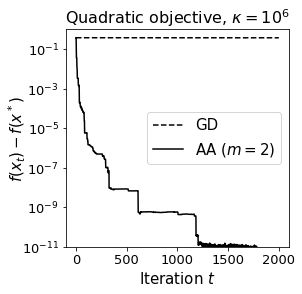

In [7]:
plt.figure(figsize=(4, 4))
plt.plot(np.array(f_hist_gd) - f_star, label="GD", 
         linestyle="--", c="k")
plt.plot(np.array(f_hist_aa) - f_star, label="AA ($m = 2$)", 
         linestyle="-", c="k")
plt.legend(loc="best", prop={'size': 15})
plt.ylim([1e-11, 1e0])
plt.yscale("log")
plt.yticks(size=13)
plt.xticks(size=13)
plt.ylabel("$f(x_t) - f(x^*)$", size=15, va="center", ha="center")
plt.xlabel("Iteration $t$", size=15, ha="center")
plt.title("Quadratic objective, $\kappa = 10^{6}$", size=16)
plt.savefig("AA_GD_quadratic.png", bbox_inches="tight", dpi=100)
plt.show()